<a href="https://colab.research.google.com/github/zjukd00m/ComputerVisionSAM/blob/main/SamAI_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything

An open source Computer Vision model that was trained on around 11M images with approximately 2B masks for segmentation tasks.

What makes this model unique is that it can segment images using user prompts and it allows to perform zero-shot learning tasks.

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-v1atpxi2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-v1atpxi2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=321a54ddc8654c3631c7c9fc1d61b73f191da100b37f75167ed6a329ce077796
  Stored in directory: /tmp/pip-ephem-wheel-cache-ra5vfeca/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [ ]:
!pip -q install opencv-python pycocotools matplotlib onnxruntime onnx

In [ ]:
import io
import os
import requests
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image

In [ ]:
# Mount the SAModel directory from google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# The path where the SAM artifacts will be downloaded
sam_model_dir = Path("/content/drive/MyDrive/Colab Notebooks/SAModel")

img_dir = sam_model_dir / "images"
checkpoint_dir = sam_model_dir / "model-checkpoints"

if not img_dir.exists():
  img_dir.mkdir()

if not checkpoint_dir:
  checkpoint_dir.mkdir()

In [ ]:
# Download an image given its url and turn them into a numpy array
def download_img(img_url: str):
  req = requests.get(img_url)

  if not req.ok:
    raise Exception(req.status_code)
  
  # Store the content into a buffer
  content = io.BytesIO(req.content)

  # Get the mymetype of the image (default is application/octect-stream)
  content_type = req.headers.get("Content-Type")

  # Convert the bytes into an image
  img = Image.open(content)

  return np.array(img), content_type

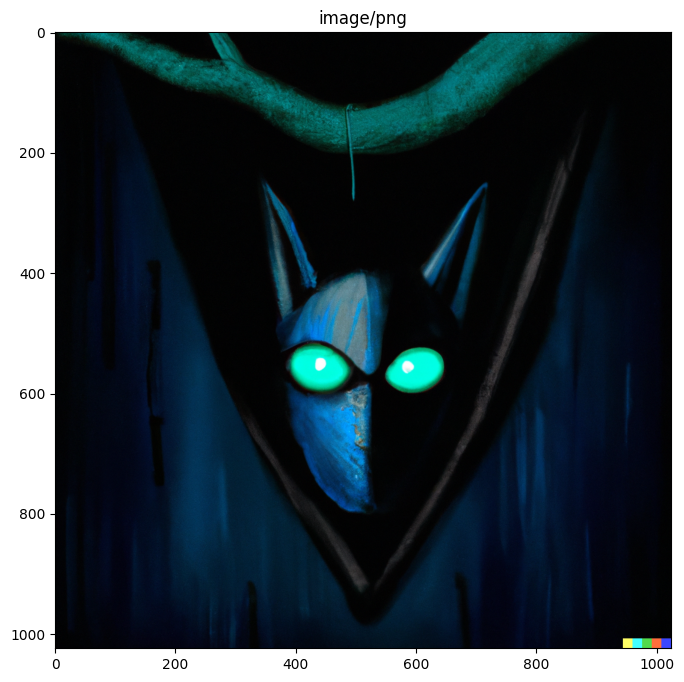

In [ ]:
img, content_type = download_img("https://zjukd00m.com/favicon.png")

plt.figure(figsize=(10, 8))
plt.title(content_type)
plt.imshow(img)
_ = plt.axis("on")

In [ ]:
# Introducing SAM
from segment_anything import SamPredictor, sam_model_registry

# Load the checkpoint that is stored at Google Drive
sam = sam_model_registry["vit_b"](
    checkpoint=sam_model_dir / "model-checkpoints" / "sam_vit_b_01ec64.pth"
)

predictor = SamPredictor(sam)

In [ ]:
# Functions that were provided by the Meta Colab
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [ ]:
# Creates an embedding for the image
predictor.set_image(img)

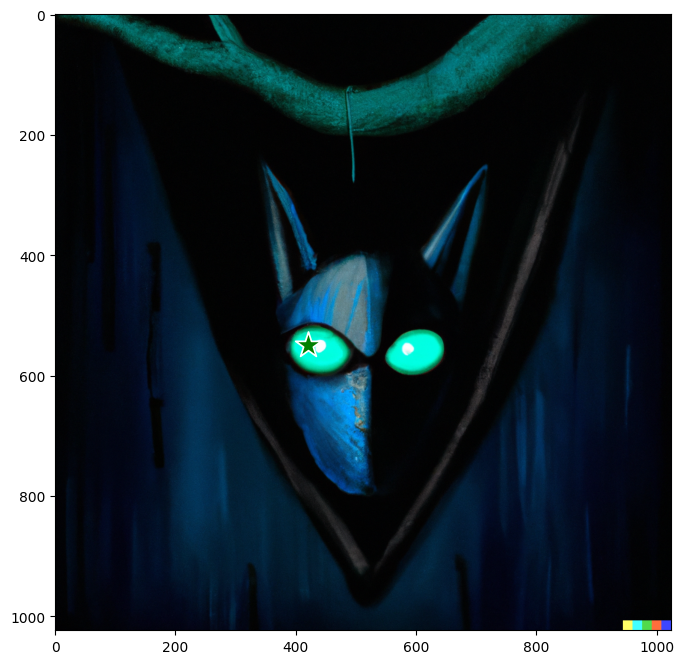

In [ ]:
point = np.array([[420, 550]])
label = np.array([1])

plt.figure(figsize=(10, 8))
plt.imshow(img)

show_points(point, label, plt.gca())

plt.show()

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=point,
    point_labels=label,
    multimask_output=True
)

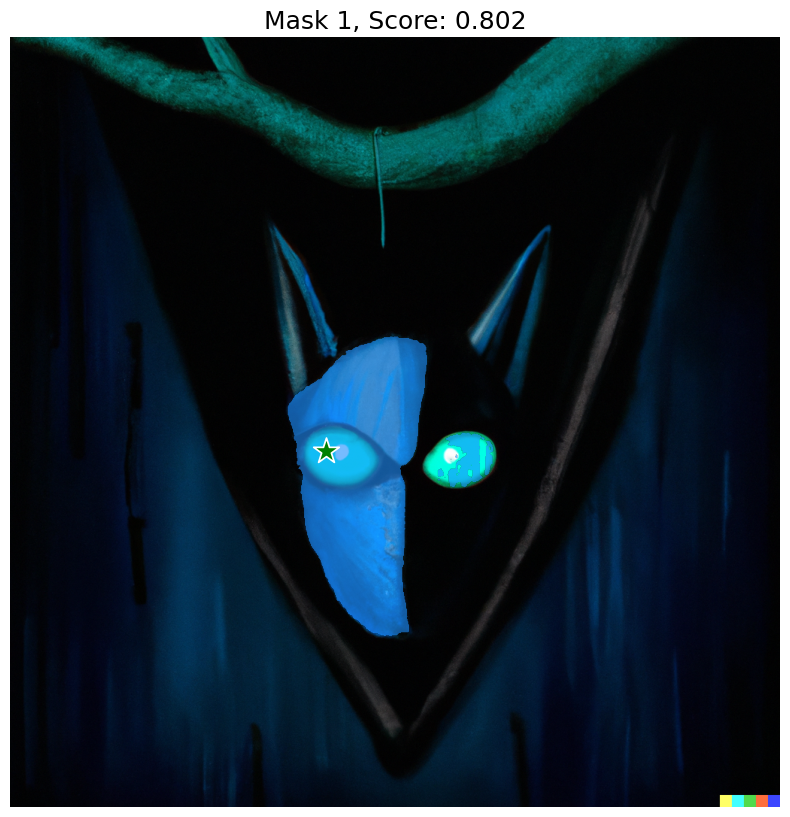

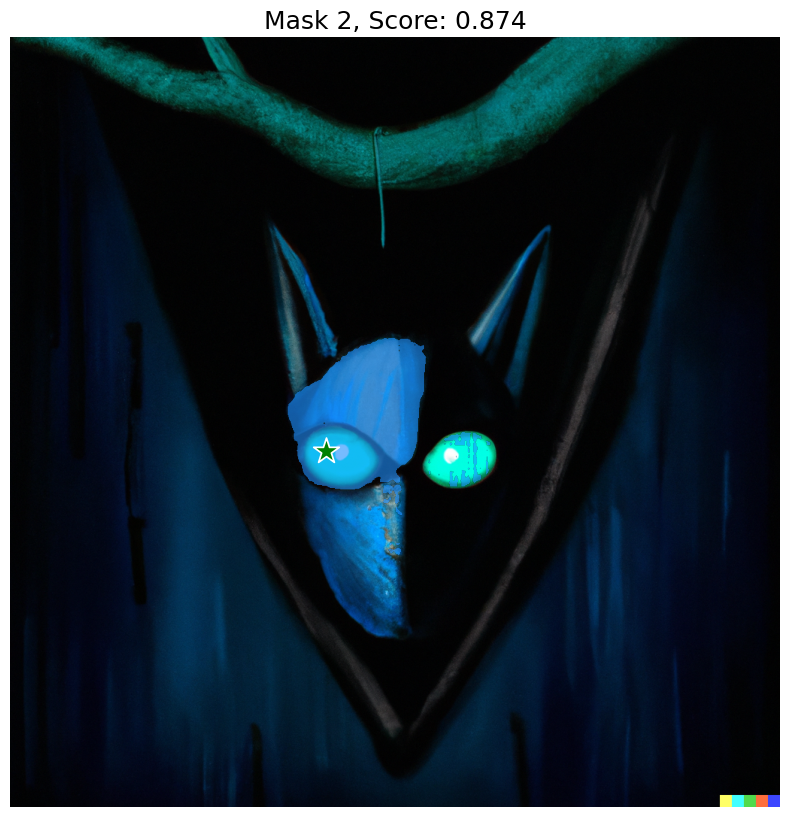

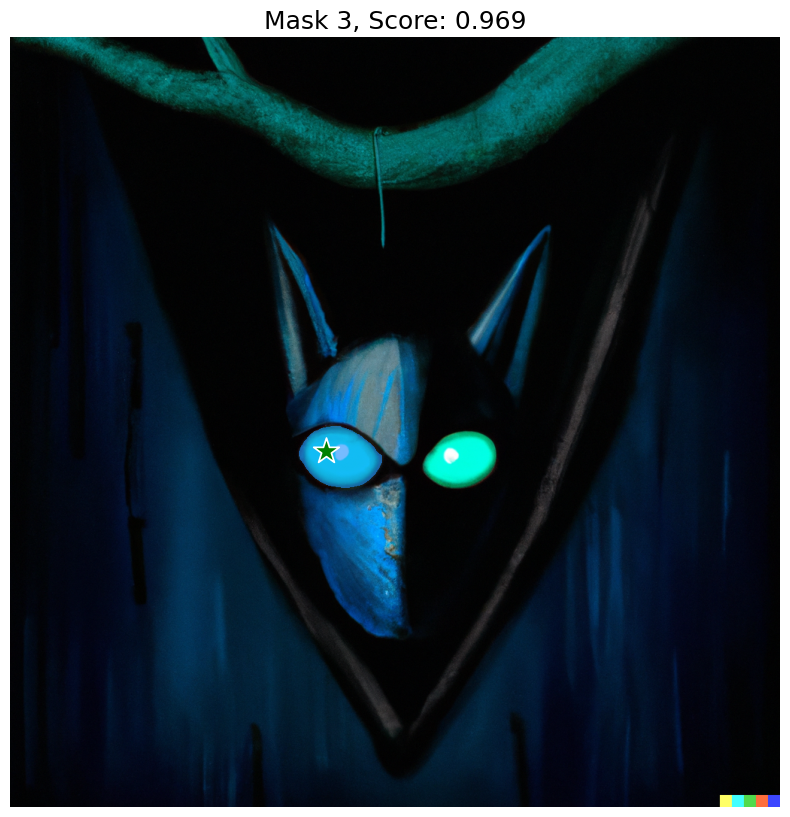

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(point, label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()